In [1]:
using PyPlot
using Seaborn
using AutomotiveDrivingModels
using NGSIM

In [2]:
typealias SparseTrajData SparseMatrixCSC{AutomotiveDrivingModels.VehicleState, Int}

SparseMatrixCSC{AutomotiveDrivingModels.VehicleState,Int64}

In [3]:
"""
    td_sparse(td::Trajdata)

Returns a sparse array and a dictionary.

In the sparse array, each column is a car; row, a frame/scene;
entry, `AutomotiveDrivingModels.VehicleState`.
Also returns a lookup table (`Dict`) of ids (`Records.RecordState.id`) to
index (column number).
"""
function td_sparse(td::Trajdata)
    # is this an efficient data pipeline?
    # probably not
    # do we care?
    # probably not

    # ids are by time of entry
    # translate id to index on range of 1:n
    id_lookup = Dict(id => index for (index, id) in
        (td.defs |> keys |> collect |> sort |> enumerate))

    m = nframes(td) # num rows
    n = nids(td) # num cols
    n_st = length(td.states)

    # the row/frame of each state
    I = Vector{Int}(n_st)
    # the column/car index (not the id, see id_lookup)
    J = similar(I)
    # the states themselves
    V = similar(I, VehicleState)

    # the index into I, J, and V (on [1:n_st])
    idx = 1
    for (fid, frame) in enumerate(td.frames)
        for stateid in frame.lo : frame.hi
            recstate = td.states[stateid]
            I[idx] = fid
            J[idx] = id_lookup[recstate.id]
            V[idx] = recstate.state

            idx += 1
        end
    end

    S = Base.sparse(I, J, V, m, n)
    return (S, id_lookup)
end

td_sparse

In [4]:
td = load_trajdata(1)
(S, id_lookup) = td_sparse(td);

A fun little plot (missing lines are plotting artifacts, not actually in the data...)

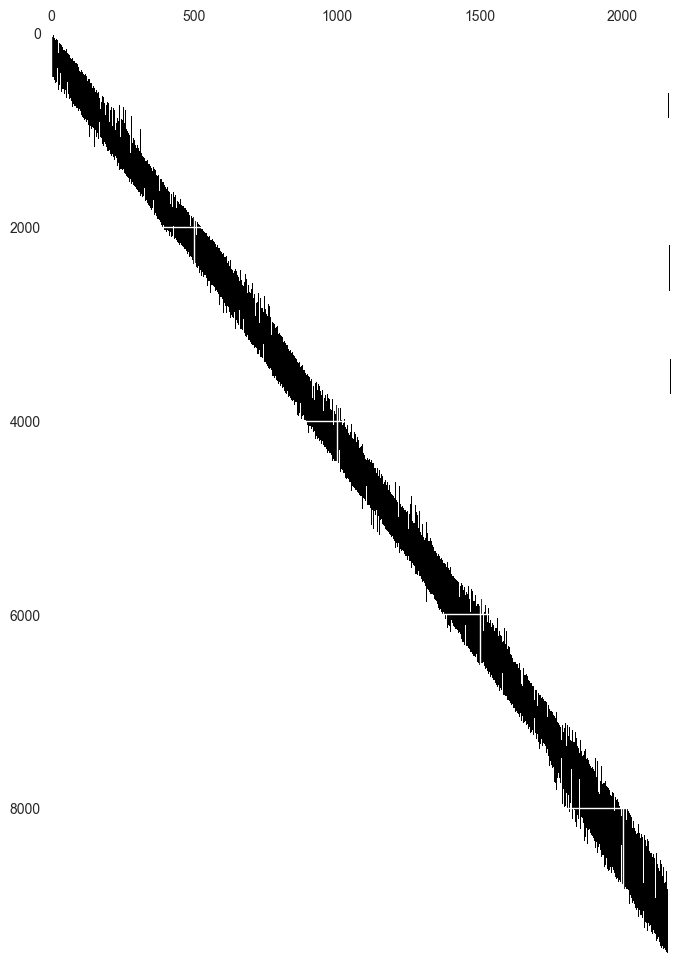

PyObject <matplotlib.image.AxesImage object at 0x00000000020A1BA8>

In [5]:
# similar type b/c no zero(::VehicleState)
S_i = similar(S, Float64)
S_i.nzval[:] = 16

fig = figure(figsize=(8, 12))
ax = fig[:gca]()
ax[:spy](S_i, aspect="auto")